In [1]:
import math
import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F
from typing import Optional, List
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet50,ResNet50_Weights
from torch import Tensor
from matplotlib import cm
from torchvision.transforms.functional import to_pil_image
import os  

In [2]:
def process_image_withhooks(img_path, model_weights=ResNet50_Weights.DEFAULT):  
    """  
    处理图片并计算特征和梯度的加权值donations_values  

    Args:  
        img_path (str): 输入图片的路径  
        model_weights: 模型的预训练权重，默认为ResNet50的默认权重  

    Returns:  
        tensor: shape (num_classes,) 的 tensor，表示各个类别的donations_values  
    """  
    # 定义预处理步骤  
    test_transform = transforms.Compose([  
        transforms.Resize(512),  
        transforms.ToTensor(),  
        transforms.Normalize(  
            mean=[0.485, 0.456, 0.406],  
            std=[0.229, 0.224, 0.225]  
        )  
    ])  

    # 获取设备  
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  

    # 初始化模型  
    model = resnet50(weights=model_weights).eval().to(device)  

    # print(f"try to open image, path：{img_path}")  
    if not img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  
        print(f"跳过非图片文件：{img_path}")  
        return None  

    # 加载图片  
    img_pil = Image.open(img_path)  

    # 预处理图片  
    input_tensor = test_transform(img_pil).unsqueeze(0).to(device)  

    # 定义前向hook  
    def forward_hook(module, inp, outp):  
        feature_map.append(outp)  

    # 定义反向hook  
    def backward_hook(module, inp, outp):  
        grad.append(outp)  

    # 初始化容器  
    feature_map = []  
    grad = []  

    # 注册hook  
    hook_layer = model.layer4[-1]  
    hook_handle = hook_layer.register_forward_hook(forward_hook)  
    grad_hook_handle = hook_layer.register_full_backward_hook(backward_hook)  

    try:  
        # 前向传播  
      
        out = model(input_tensor)  
        cls_idx = torch.argmax(out).item()  
        # 计算预测类别分数  
        score = out[:, cls_idx].sum()  

        # 反向传播  
        model.zero_grad()  
        score.backward(retain_graph=False)  # 减少内存占用  

        # 获取特征和梯度  
        weights = grad[0][0].squeeze(0).mean(dim=(1, 2))  #GAP(a)
        mean_values = feature_map[0].squeeze(0).mean(dim=(1, 2))  

        # 计算加权后的值  
        donations_values = mean_values * weights  
        # donations_values = mean_values

        return donations_values.detach().cpu(),weights.detach().cpu(),mean_values.detach().cpu()

    except Exception as e:  
        print(f"处理过程中出现错误：{e}")  
        return None  

    finally:  
        # 删除hook并清理数据  
        hook_handle.remove()  
        grad_hook_handle.remove()  
        feature_map.clear()  
        grad.clear()  

        # 删除GPU上的张量并释放内存  
        if input_tensor.is_cuda:  
            del input_tensor  
            torch.cuda.empty_cache()  

        if 'out' in locals():  
            del out  
        if 'score' in locals():  
            del score

In [3]:

# 配置PyTorch的内存分配参数，减少内存碎片  
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True' 

def process_batch_images(class_path, batch_size=8, device=None, limit_num=100):  
    """批量处理一个类别下的所有图片，并返回每张图片的donations_values、weights和mean_values列表  

    Args:  
        class_path (str): 类别图片的路径  
        batch_size (int): 批次大小，缺省值为8  
        device (str or torch.device, optional): 设备类型（"cpu" 或 "cuda"），缺省值为None，会自动检测  
        limit_num (int): 限制处理的图片数量，缺省值为100  

    Returns:  
        tuple: 包含三个列表，每个列表的元素是字典，字典包含图片路径和对应的值：  
            - donations_values_list (list): 每张图片的 {'img_path': str, 'donations_values': tensor} 列表  
            - weights_list (list): 每张图片的 {'img_path': str, 'weights': tensor} 列表  
            - mean_values_list (list): 每张图片的 {'img_path': str, 'mean_values': tensor} 列表  
    """  
    if device is None:  
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
    print()  
    print("使用设备：" + str(device))  
    print("分析目录：" + str(class_path))  

    # 初始化返回的三个列表  
    donations_values_list = []  
    weights_list = []  
    mean_values_list = []  

    # 获取图片文件路径列表  
    img_paths = [  
        os.path.join(class_path, f)  
        for f in os.listdir(class_path)  
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))  
    ]  

    # 计算总批次数  
    total_batches = len(img_paths) // batch_size  
    if len(img_paths) % batch_size != 0:  
        total_batches += 1  

    succeed_count = 0  # 记录成功处理的图片数量  

    # 分批次处理图片  
    for batch_idx in range(total_batches):  
        start = batch_idx * batch_size  
        end = min((batch_idx + 1) * batch_size, len(img_paths))  
        batch_paths = img_paths[start:end]  

        # 逐张处理图片以减少内存占用  
        for img_path in batch_paths:  
            if succeed_count >= limit_num:  
                print(f"已达到限制数量 {limit_num}，停止处理。")  
                break  

            try:  
                # 调用process_image_withhooks处理图片  
                result = process_image_withhooks(img_path)  

                if result is not None:  
                    donations_values, weights, mean_values = result  
                    # 将结果和图片路径组成字典，并添加到对应的列表中  
                    donations_values_list.append( donations_values)  
                    weights_list.append(weights)  
                    mean_values_list.append( mean_values)  
                    succeed_count += 1  

                    if succeed_count >= limit_num:  
                        print(f"已达到限制数量 {limit_num}，停止处理。")  
                        # 提前终止外层循环  
                        batch_idx = total_batches  # 强制退出外层循环  
                        break  

            except Exception as e:  
                print(f"处理 {img_path} 时发生错误：{str(e)}")  
                continue  

        # 检查是否需要提前终止外层循环  
        if succeed_count >= limit_num:  
            print(f"已达到限制数量 {limit_num}，停止处理。")  
            break  

    print(f"成功处理的图片总数：{succeed_count}")  
    return donations_values_list, weights_list, mean_values_list  

In [4]:
class_path1 = "dataset/n02105505/" #匈牙利牧羊犬  
class_path2 = "dataset/n02101006/" #戈登雪达犬
donations_values_list1, weights_list1, mean_values_list1 = process_batch_images(class_path1, batch_size=8,limit_num=100)  
donations_values_list2, weights_list2, mean_values_list2 = process_batch_images(class_path2, batch_size=8,limit_num=50) 



使用设备：cuda
分析目录：dataset/n02105505/


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/featurize/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


已达到限制数量 100，停止处理。
已达到限制数量 100，停止处理。
成功处理的图片总数：100

使用设备：cuda
分析目录：dataset/n02101006/
已达到限制数量 50，停止处理。
已达到限制数量 50，停止处理。
成功处理的图片总数：50


In [6]:
# 访问第一张图片的路径和 donations_values
first_img_path = donations_values_list1[0]['img_path']
first_donations = donations_values_list1[0]['donations_values']

print(f"图片路径: {first_img_path}")
print(f"Donations Values: {first_donations}")

图片路径: dataset/n02105505/n02105505_37.jpg
Donations Values: tensor([ 3.9757e-07, -1.1534e-06,  2.2901e-07,  ..., -0.0000e+00,
         0.0000e+00, -0.0000e+00])


In [9]:
import os  
import torch  
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.decomposition import PCA  
from sklearn.preprocessing import StandardScaler  

def cluster_mixed_class_batches(donations_list1, donations_list2, n_clusters=2):  
    """混合处理两个donations_values_list，打上不同的类别标签，并进行K-means聚类  

    Args:  
        donations_list1 (list): 第一个类别的donations_values列表  
        donations_list2 (list): 第二个类别的donations_values列表  
        n_clusters (int, optional): K-means聚类的簇数，缺省值为2  

    Returns:  
        tuple: 包含聚类标签、聚类中心、降维后的数据点以及原始类别标签，分别是：  
            - cluster_labels (np.ndarray): 每个数据点的簇标签  
            - cluster_centers (np.ndarray): 簇中心  
            - principal_components (np.ndarray): 降维后的数据点  
            - original_labels (np.ndarray): 每个数据点的原始类别标签  
    """  
    # 创建目标类别标签  
    # donations_list1的标签为0，donations_list2的标签为1  
    targets = np.concatenate([np.zeros(len(donations_list1)), np.ones(len(donations_list2))])  

    # 合并两个donations_values列表  
    combined_donations = donations_list1 + donations_list2  

    # 将torch.Tensor列表转换为NumPy数组  
    combined_donations_np = np.array([tensor.cpu().numpy() for tensor in combined_donations])  

    # 数据预处理：标准化  
    scaler = StandardScaler()  
    scaled_data = scaler.fit_transform(combined_donations_np)  

    # 降维至n_components维度，使用PCA  
    n_components = 2  # 可以根据需要调整  
    pca = PCA(n_components=n_components)  
    principal_components = pca.fit_transform(scaled_data)  

    # 初始化K-means模型并进行聚类  
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)  
    cluster_labels = kmeans.fit_predict(principal_components)  

    # 获取聚类中心  
    cluster_centers = kmeans.cluster_centers_  

    return cluster_labels, cluster_centers, principal_components, targets

In [34]:
import matplotlib.pyplot as plt  
import numpy as np  

def plot_cluster_results(cluster_labels, cluster_centers, principal_components, original_labels, n_clusters=None, class_names=None):  
    """  
    可视化聚类结果，并统计不同簇中不同标签样本的数量。  
    在每个簇中，为不同类别的样本分配不同的形状和颜色。  

    Args:  
        cluster_labels (np.ndarray): 每个数据点的簇标签。  
        cluster_centers (np.ndarray): 每个簇的中心坐标。  
        principal_components (np.ndarray): 降维后的数据点坐标。  
        original_labels (np.ndarray): 原始的类别标签。  
        n_clusters (int, optional): 簇的数量，用于检查 cluster_labels 的有效性。缺省值为None。  
        class_names (list, optional): 类别的名称列表，用于图例显示。缺省值为None。  

    Returns:  
        plt.Figure: 返回Matplotlib的Figure对象，以便进一步自定义或保存图表。  
    """  

    if n_clusters is not None:  
        if cluster_labels.max() >= n_clusters or cluster_labels.min() < 0:  
            raise ValueError("cluster_labels 中的值超出了预期的范围。")  

    unique_clusters = np.unique(cluster_labels)  
    n_clusters_total = len(unique_clusters) if n_clusters is None else n_clusters  

    # 统计每个簇中的每个原始类别的数量  
    cluster_class_counts = []  
    for cluster_label in unique_clusters:  
        mask = cluster_labels == cluster_label  
        class_counts = []  
        for orig_label in np.unique(original_labels):  
            count = np.sum(original_labels[mask] == orig_label)  
            class_counts.append(count)  
        cluster_class_counts.append(class_counts)  
    
    if class_names is not None:  
        # 获取排序后的唯一orig_label  
        unique_orig_labels = np.sort(np.unique(original_labels))  
        
        # 验证class_names的长度  
        if len(unique_orig_labels) != len(class_names):  
            raise ValueError("The number of unique original labels does not match the length of class_names.")  
        
        # 创建映射字典  
        class_name_mapping = {orig_label: class_name for orig_label, class_name in zip(unique_orig_labels, class_names)}  
        
        # 打印映射后的统计信息  
        for i, cluster_label in enumerate(unique_clusters):  
            counts = cluster_class_counts[i]  
            class_count_str = ", ".join([f"Class {class_name_mapping[orig_label]}: {count}" for orig_label, count in zip(unique_orig_labels, counts)])  
            print(f"Cluster {cluster_label}: {class_count_str}")  
    else:  
        # 如果class_names为None，保留原有打印方式  
        for i, cluster_label in enumerate(unique_clusters):  
            counts = cluster_class_counts[i]  
            class_count_str = ", ".join([f"Class {orig_label}: {count}" for orig_label, count in zip(np.unique(original_labels), counts)])  
            print(f"Cluster {cluster_label}: {class_count_str}")  

    # 创建图表和子图  
    fig, ax = plt.subplots(figsize=(10, 8))  

    # 定义形状映射，确保每个簇有一个独特的形状  
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H']  # 增加更多形状  
    num_markers = len(markers)  

    # 定义颜色映射，确保每个类别-簇组合有一个独特的颜色  
    # 使用tab20颜色映射，提供更多的颜色选择  
    num_colors = len(np.unique(original_labels)) * len(unique_clusters)  
    colors = plt.cm.tab20(np.linspace(0, 1, num_colors))  

    # 创建颜色映射字典  
    color_mapping = {}  
    color_idx = 0  
    for cluster_label in unique_clusters:  
        for orig_label in np.unique(original_labels):  
            color_mapping[(cluster_label, orig_label)] = colors[color_idx]  
            color_idx += 1  

    # 为每个簇分配形状  
    cluster_marker = {}  
    for idx, cluster_label in enumerate(unique_clusters):  
        cluster_marker[cluster_label] = markers[idx % num_markers]  # 循环分配形状  

    # 绘制每个类别在每个簇中的样本，增加点的大小  
    for cluster_label in unique_clusters:  
        mask = cluster_labels == cluster_label  
        cluster_shape = cluster_marker[cluster_label]  

        for orig_label in np.unique(original_labels):  
            sub_mask = mask & (original_labels == orig_label)  
            if np.any(sub_mask):  
                color = color_mapping[(cluster_label, orig_label)]  

                if class_names is not None:  
                    class_name = class_name_mapping[orig_label]  
                    label_str = f'Cluster {cluster_label}, Class {class_name}'  
                else:  
                    label_str = f'Cluster {cluster_label}, Class {orig_label}'  

                ax.scatter(  
                    principal_components[sub_mask, 0],  
                    principal_components[sub_mask, 1],  
                    c=[color],  
                    marker=cluster_shape,  
                    s=80,  # 增加样本点的大小  
                    label=label_str  
                )  

    # 绘制簇中心  
    ax.scatter(  
        cluster_centers[:, 0],  
        cluster_centers[:, 1],  
        marker='*',  
        s=200,  
        c='red',  
        label='Cluster Centers'  
    )  

    # 设置图表标题和坐标轴标签  
    ax.set_title('Cluster Analysis with Principal Components')  
    ax.set_xlabel('Principal Component 1')  
    ax.set_ylabel('Principal Component 2')  

    # 自动调整图表布局  
    plt.tight_layout()  

    # 显示图例，确保清晰  
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')  

    return fig  

Cluster 0: Class A: 98, Class B: 5
Cluster 1: Class A: 2, Class B: 45


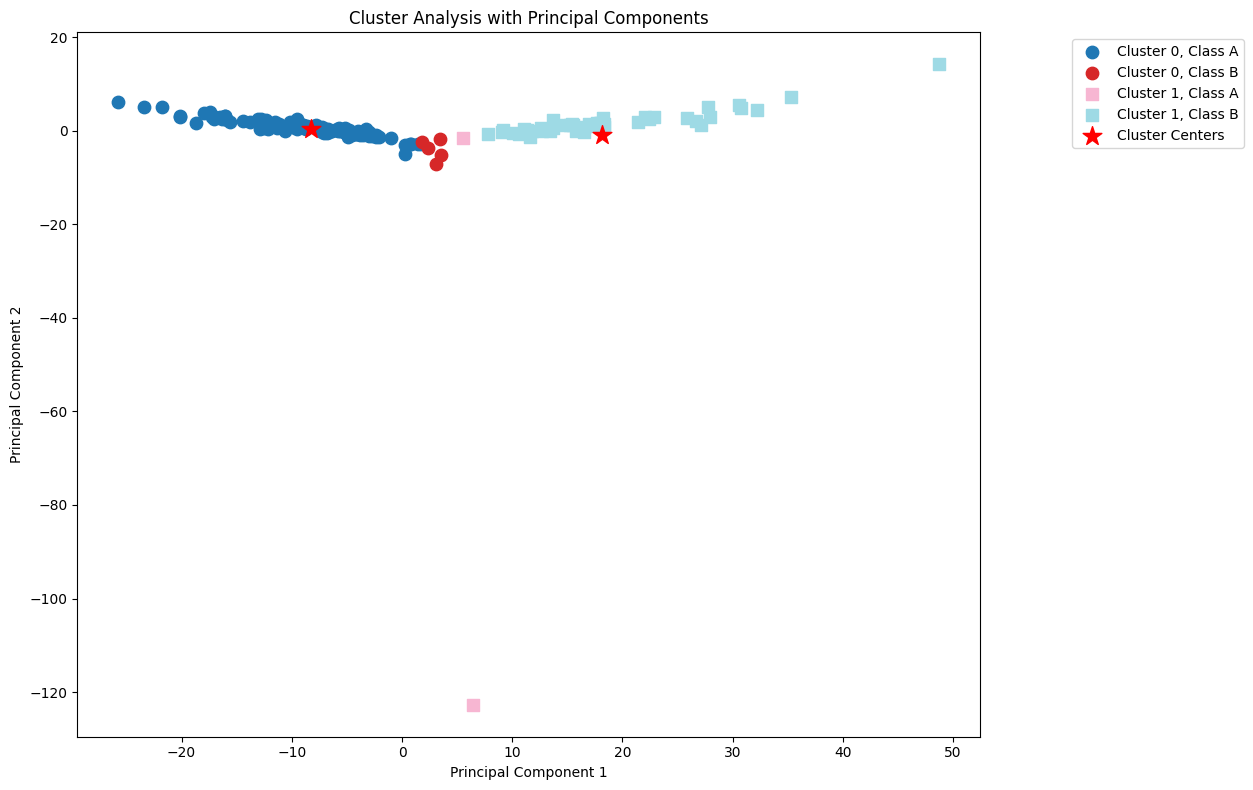

In [41]:
cluster_labels, cluster_centers, principal_components, original_labels = cluster_mixed_class_batches(
    donations_values_list1, donations_values_list2, n_clusters=2)  

# 定义类别名称  
class_names = ['A', 'B']  

# 调用plot_cluster_results函数  
fig = plot_cluster_results(  
    cluster_labels=cluster_labels,  
    cluster_centers=cluster_centers,  
    principal_components=principal_components,  
    original_labels=original_labels,  
    n_clusters=2,  
    class_names=class_names  
)  

# 显示图表  
plt.show() 

Cluster 0: Class A: 100, Class B: 5
Cluster 1: Class A: 0, Class B: 45


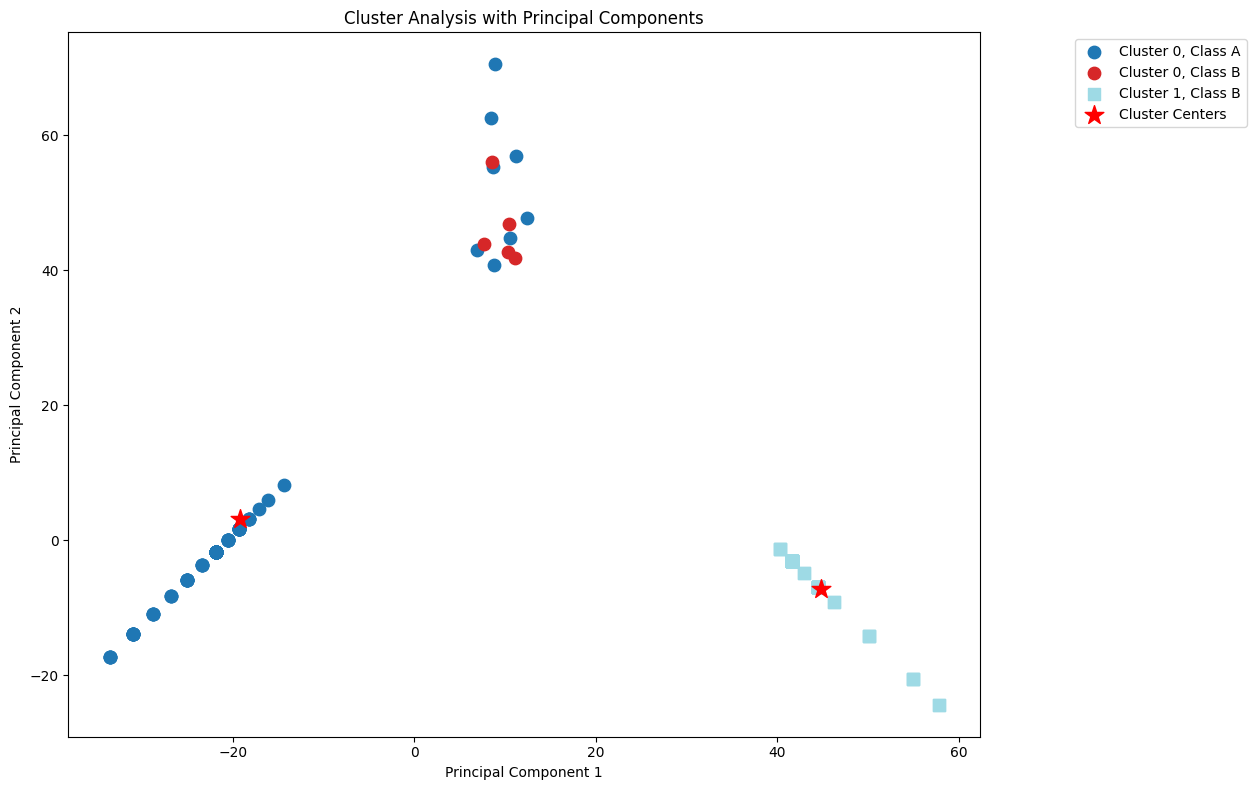

In [40]:
cluster_labels, cluster_centers, principal_components, original_labels = cluster_mixed_class_batches(
    weights_list1, weights_list2, n_clusters=2)  

# 定义类别名称 
class_names = ['A', 'B']  

# 调用plot_cluster_results函数  
fig = plot_cluster_results(  
    cluster_labels=cluster_labels,  
    cluster_centers=cluster_centers,  
    principal_components=principal_components,  
    original_labels=original_labels,  
    n_clusters=2,  
    class_names=class_names  
)  

# 显示图表  
plt.show() 

Cluster 0: Class A: 35, Class B: 19
Cluster 1: Class A: 65, Class B: 31


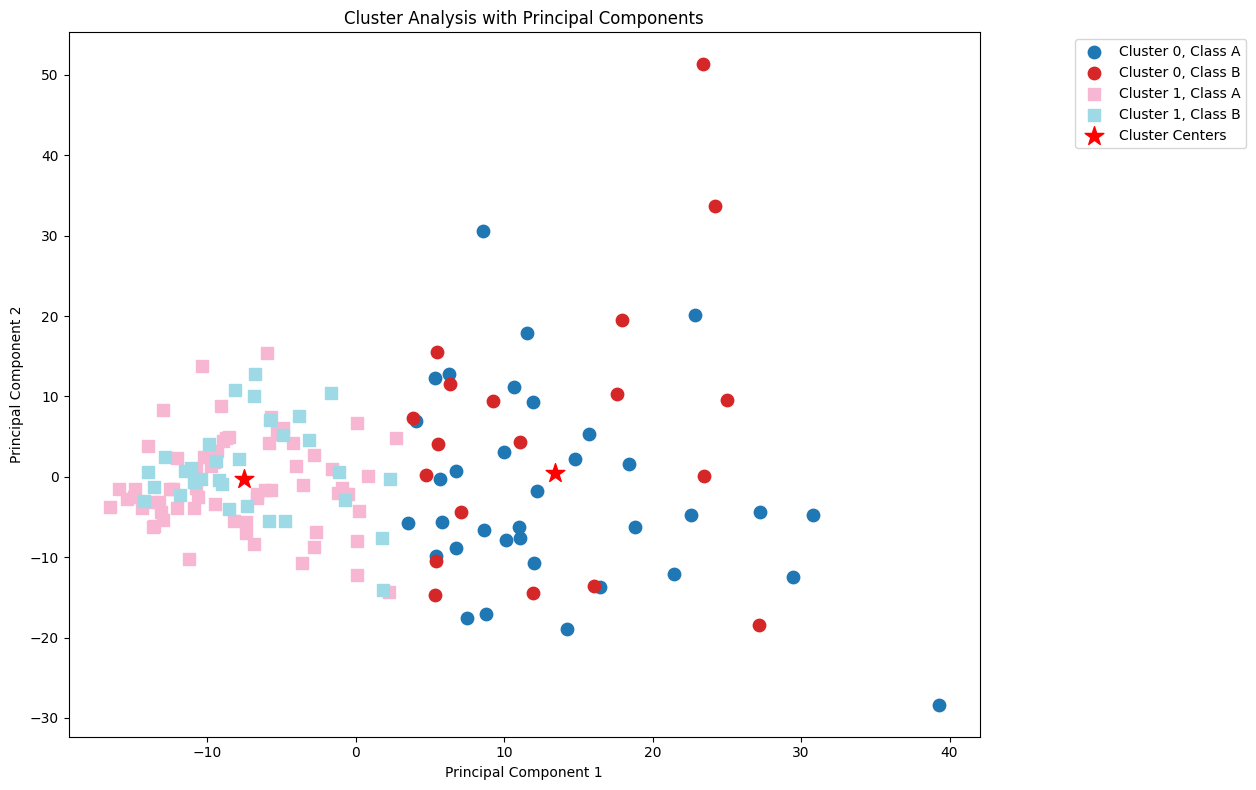

In [39]:
cluster_labels, cluster_centers, principal_components, original_labels = cluster_mixed_class_batches(
    mean_values_list1, mean_values_list2, n_clusters=2)  

# 定义类别名称  
class_names = ['A', 'B']  

# 调用plot_cluster_results函数  
fig = plot_cluster_results(  
    cluster_labels=cluster_labels,  
    cluster_centers=cluster_centers,  
    principal_components=principal_components,  
    original_labels=original_labels,  
    n_clusters=2,  
    class_names=class_names  
)  

# 显示图表  
plt.show() 

In [ ]:
class_path1 = "dataset/n02105505/" #匈牙利牧羊犬  
class_path2 = "dataset/n02101006/" #戈登雪达犬
donations_values_list1, weights_list2, mean_values_list1 = process_batch_images(class_path1, batch_size=8,limit_num=50)  
donations_values_list2, weights_list2, mean_values_list2 = process_batch_images(class_path2, batch_size=8,limit_num=50) 


In [ ]:
cluster_labels, cluster_centers, principal_components, original_labels = cluster_mixed_class_batches(
    donations_values_list1, donations_values_list2, n_clusters=2)  

# 定义类别名称  
class_names = ['A', 'B']  

# 调用plot_cluster_results函数  
fig = plot_cluster_results(  
    cluster_labels=cluster_labels,  
    cluster_centers=cluster_centers,  
    principal_components=principal_components,  
    original_labels=original_labels,  
    n_clusters=2,  
    class_names=class_names  
)  

# 显示图表  
plt.show()